# Imports

In [1]:
%pip install -r requirements3_9.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rdflib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from pyrdf2vec.graphs import kg
from pyrdf2vec.rdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import Vertex
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.samplers import UniformSampler, ObjFreqSampler, PredFreqSampler
from pyrdf2vec.walkers import RandomWalker, WLWalker, WalkletWalker
import random

# Files

In [3]:
gene_ontology_file_path = '../DB/go.owl'
protein_file_path = '../DB/9606.protein.enrichment.terms.v12.0.txt'
protein_links_file_path = '../DB/9606.protein.links.v12.0.txt'
protein_full_links_file_path = '../DB/9606.protein.links.detailed.v12.0.txt'

data = pd.read_csv(protein_links_file_path, sep=" ", header=0)
data

# Creating the Knowledge graph

In [4]:
g = rdflib.Graph()
g.parse(gene_ontology_file_path, format = 'xml');

In [5]:
prots = []

with open(protein_file_path , 'r') as prot_annot:
    prot_annot.readline()
    for line in prot_annot:
        elements_annot = line.split('\t')
        id_prot, GO_term = elements_annot[0], elements_annot[2]
        if GO_term.startswith('GO:') :
            url_GO_term = 'http://purl.obolibrary.org/obo/GO_' + GO_term.split(':')[1]
            url_prot = 'https://string-db.org/network/' + id_prot
            if id_prot not in prots:
                prots.append(id_prot)
            #if (id_prot in data2["protein1"].values or id_prot in data2["protein2"].values) and url_prot not in prots:
            #    prots.append(url_prot)
            g.add((rdflib.term.URIRef(url_prot), rdflib.term.URIRef('http://purl.obolibrary.org/obo/go.owl#has_function') , rdflib.term.URIRef(url_GO_term)))

# Distribution of Confidence

data = data[data["protein1"].isin(prots) & data["protein2"].isin(prots)]
data

In [6]:
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)]
data_full

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,0,0,0,45,134,0,81,173
1,9606.ENSP00000000233,9606.ENSP00000427567,0,0,0,0,128,0,70,154
2,9606.ENSP00000000233,9606.ENSP00000253413,0,0,0,118,49,0,69,151
3,9606.ENSP00000000233,9606.ENSP00000493357,0,0,0,56,53,0,457,471
4,9606.ENSP00000000233,9606.ENSP00000324127,0,0,0,0,46,0,197,201
...,...,...,...,...,...,...,...,...,...,...
13715398,9606.ENSP00000501317,9606.ENSP00000360858,0,0,0,0,0,0,328,327
13715399,9606.ENSP00000501317,9606.ENSP00000475489,0,0,0,60,99,0,126,195
13715400,9606.ENSP00000501317,9606.ENSP00000370447,0,0,0,55,111,0,79,158
13715401,9606.ENSP00000501317,9606.ENSP00000312272,0,0,0,0,0,0,227,226


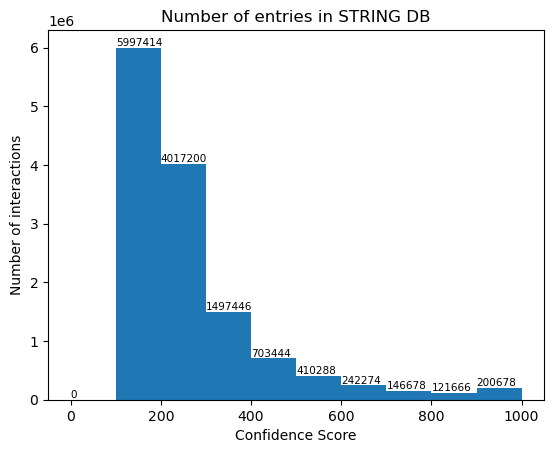

In [7]:
# Create a histogram and get the patches
counts, bins, patches = plt.hist(data_full['combined_score'], bins=10, bottom=list(range(0,1000,100)), range=(0,1000))

# Set the title and labels
plt.title('Number of entries in STRING DB')
plt.xlabel('Confidence Score')
plt.ylabel('Number of interactions')

# Annotate histogram with the number of data points in each bin
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(bin, height, str(int(count)), va='bottom', fontsize=7.5)

plt.show()

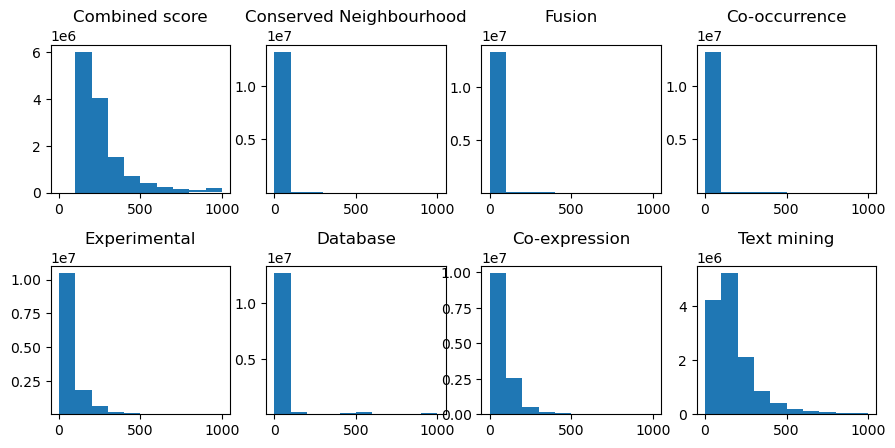

In [8]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].hist(data_full['combined_score'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 0].set_title('Combined score', y=1.1)  # Increase the y parameter to move the title up
axs[0, 1].hist(data_full['neighborhood'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 1].set_title('Conserved Neighbourhood', y=1.1)
axs[0, 2].hist(data_full['fusion'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 2].set_title('Fusion', y=1.1)
axs[0, 3].hist(data_full['cooccurence'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 3].set_title('Co-occurrence', y=1.1)
axs[1, 0].hist(data_full['experimental'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 0].set_title('Experimental', y=1.1)
axs[1, 1].hist(data_full['database'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 1].set_title('Database', y=1.1)
axs[1, 2].hist(data_full['coexpression'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 2].set_title('Co-expression', y=1.1)
axs[1, 3].hist(data_full['textmining'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 3].set_title('Text mining', y=1.1);

plt.subplots_adjust(left=0.01, right=1.3, hspace=0.5)

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

# Creating thresholds

In [9]:
# Thresholds for the whole dataset

# data8 = data_full.where(data_full['combined_score']>800).copy().dropna().reset_index(drop=True)
# data6 = data_full.where(data_full['combined_score']>600).copy().dropna().reset_index(drop=True)
# data4 = data_full.where(data_full['combined_score']>400).copy().dropna().reset_index(drop=True)
# data2 = data_full.where(data_full['combined_score']>200).copy().dropna().reset_index(drop=True)
# dataSample = data_full

# Thresholds for fixed size sampling (1000 samples)

data8 = data_full.where(data_full['combined_score']>800).copy().dropna().reset_index(drop=True).sample(n=1000, random_state=42)
data6 = data_full.where(data_full['combined_score']>600).copy().dropna().reset_index(drop=True).sample(n=1000,random_state=42)
data4 = data_full.where(data_full['combined_score']>400).copy().dropna().reset_index(drop=True).sample(n=1000,random_state=42)
data2 = data_full.where(data_full['combined_score']>200).copy().dropna().reset_index(drop=True).sample(n=1000,random_state=42)
dataSample = data_full.sample(n=1000,random_state=42)

# Thresholds for fraction sampling (10% of the data)

# data8 = data_full.where(data_full['combined_score']>800).copy().dropna().reset_index(drop=True).sample(frac=0.1, random_state=42)
# data6 = data_full.where(data_full['combined_score']>600).copy().dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
# data4 = data_full.where(data_full['combined_score']>400).copy().dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
# data2 = data_full.where(data_full['combined_score']>200).copy().dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
# dataSample = data_full.sample(frac=0.1,random_state=42)


# Thresholds for uniform sampling

# select = []
# for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
# data8 = data8.loc[select]
#select = []
#for N in range(1000):
#    ind = int(N*len(data6)/1000)
#    select.append(ind)
#data6 = data6.loc[select]
#select = []
#for N in range(1000):
#    ind = int(N*len(data4)/1000)
#    select.append(ind)
#data4 = data4.loc[select]
#select = []
#for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
#data2 = data2.loc[select]
#select = []
#for N in range(1000):
#    ind = int(N*len(dataSample)/1000)
#    select.append(ind)
#dataSample = dataSample.reset_index(drop=True).loc[select]

# Pipeline

In [10]:
# Defining rdf2vec paramenters
vector_size = 200
n_walks = 100
type_word2vec = 'skip-gram'
walk_depth = 4
walker_type = 'wl'
sampler_type = 'uniform'

# Creating a pyrdf2vec graph
g_pyrdf2vec = kg.KG(mul_req=False)
for (s, p, o) in g:
    s_v = Vertex(str(s))
    o_v = Vertex(str(o))
    p_v = Vertex(str(p), predicate=True, vprev=s_v, vnext=o_v)
    g_pyrdf2vec.add_vertex(s_v)
    g_pyrdf2vec.add_vertex(p_v)
    g_pyrdf2vec.add_vertex(o_v)
    g_pyrdf2vec.add_edge(s_v, p_v)
    g_pyrdf2vec.add_edge(p_v, o_v)

# Defining the word2vec strategy
if type_word2vec == 'CBOW':
    sg_value = 0
elif type_word2vec == 'skip-gram':
    sg_value = 1

# Defining sampling strategy 
if sampler_type.lower() == 'uniform':
    sampler = UniformSampler()
elif sampler_type.lower() == 'predfreq':
    sampler = PredFreqSampler()
elif sampler_type.lower() == 'objfreq':
    sampler = ObjFreqSampler()

# Defining warker strategy
if walker_type.lower() == 'random':
    walker = RandomWalker(max_depth=walk_depth, max_walks=n_walks, sampler = sampler)
elif walker_type.lower() == 'wl':
    walker = WLWalker(max_depth=walk_depth, max_walks=n_walks, sampler = sampler)
elif walker_type.lower() == 'walklet':
    walker = WalkletWalker(max_depth=walk_depth, max_walks=n_walks, sampler = sampler)

# Training RDF2Vec embeddings    
transformer = RDF2VecTransformer(Word2Vec(vector_size=vector_size, sg=sg_value), walkers=[walker])

# For data with higher Score than 800

# Generating the Embeddings

In [11]:
prots = []

for value in data8["protein1"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

for value in data8["protein2"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

#prots

In [12]:

embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
# Saving embedding in a dictionary
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
#print(dict_embeddings)

KeyboardInterrupt: 

In [ ]:
pairs_prots = []
for d in data8.values:
    pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

pairs_prots = set(pairs_prots)
len(pairs_prots)

31923

In [ ]:
negative_pairs_prots = []
for prot in prots:
    for prot2 in prots:
        if (prot,prot2,1) in pairs_prots:
            continue
        elif prot != prot2:
            negative_pairs_prots.append((prot,prot2,0))

negative_pairs_prots = random.sample(negative_pairs_prots, len(pairs_prots))
len(negative_pairs_prots)

31923

In [ ]:
# Generating pair representations using haddamard operator # other possibilities are concatenation, wl-1 or wl-2
X, y = [], []
for prot1, prot2, label in pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

for prot1, prot2, label in negative_pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

In [ ]:
f1_8 = []

# Creating training set and test set
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
X, y = np.array(X), np.array(y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # Training Random Forest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Obtaining predictions
    pred_test = rf_model.predict(X_test)

    # Computing performance metrics
    #f1_noninteract, f1_interact = metrics.f1_score(y_test, pred_test, average=None)
    weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
    #precision = metrics.precision_score(y_test, pred_test)
    #recall = metrics.recall_score(y_test, pred_test)
    #accuracy = metrics.accuracy_score(y_test, pred_test)
    f1_8.append(weighted_avg_f1)

# Printing performance metrics
#print('Performance metrics:')
#print('F-measure (class 1) = ' + str(f1_interact))
#print('F-measure (class 0) = ' + str(f1_noninteract))
print('Weighted Average F-measure = ' + str(np.mean(f1_8)))
#print('Precision = ' + str(precision))
#print('Recall = ' + str(recall))
#print('Accuracy = ' + str(accuracy))

Weighted Average F-measure = 0.8240076745851219


# For data with higher Score than 600

# Generating the Embeddings

In [ ]:
prots = []

for value in data6["protein1"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

for value in data6["protein2"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

#prots

In [ ]:
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
# Saving embedding in a dictionary
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
#print(dict_embeddings)

In [ ]:
pairs_prots = []
for d in data6.values:
    pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

pairs_prots = set(pairs_prots)
len(pairs_prots)

70836

In [ ]:
negative_pairs_prots = []
for prot in prots:
    for prot2 in prots:
        if (prot,prot2,1) in pairs_prots:
            continue
        elif prot != prot2:
            negative_pairs_prots.append((prot,prot2,0))

negative_pairs_prots = random.sample(negative_pairs_prots, len(pairs_prots))

In [ ]:
# Generating pair representations using haddamard operator # other possibilities are concatenation, wl-1 or wl-2
X, y = [], []
for prot1, prot2, label in pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

for prot1, prot2, label in negative_pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))


In [ ]:
f1_6 = []

# Creating training set and test set
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
X, y = np.array(X), np.array(y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # Training Random Forest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Obtaining predictions
    pred_test = rf_model.predict(X_test)

    # Computing performance metrics
    #f1_noninteract, f1_interact = metrics.f1_score(y_test, pred_test, average=None)
    weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
    #precision = metrics.precision_score(y_test, pred_test)
    #recall = metrics.recall_score(y_test, pred_test)
    #accuracy = metrics.accuracy_score(y_test, pred_test)
    f1_6.append(weighted_avg_f1)

# Printing performance metrics
#print('Performance metrics:')
#print('F-measure (class 1) = ' + str(f1_interact))
#print('F-measure (class 0) = ' + str(f1_noninteract))
print('Weighted Average F-measure = ' + str(np.mean(f1_6)))
#print('Precision = ' + str(precision))
#print('Recall = ' + str(recall))
#print('Accuracy = ' + str(accuracy))

Weighted Average F-measure = 0.8161339688441045


# For data with higher Score than 400

# Generating the Embeddings

In [ ]:
prots = []

for value in data4["protein1"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

for value in data4["protein2"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

#prots

In [ ]:
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
# Saving embedding in a dictionary
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
#print(dict_embeddings)

In [ ]:
pairs_prots = []
for d in data4.values:
    pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

pairs_prots = set(pairs_prots)
len(pairs_prots)

180340

In [ ]:
negative_pairs_prots = []
for prot in prots:
    for prot2 in prots:
        if (prot,prot2,1) in pairs_prots:
            continue
        elif prot != prot2:
            negative_pairs_prots.append((prot,prot2,0))

negative_pairs_prots = random.sample(negative_pairs_prots, len(pairs_prots))

In [ ]:
# Generating pair representations using haddamard operator # other possibilities are concatenation, wl-1 or wl-2
X, y = [], []
for prot1, prot2, label in pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

for prot1, prot2, label in negative_pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))


In [ ]:
f1_4 = []

# Creating training set and test set
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
X, y = np.array(X), np.array(y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # Training Random Forest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Obtaining predictions
    pred_test = rf_model.predict(X_test)

    # Computing performance metrics
    #f1_noninteract, f1_interact = metrics.f1_score(y_test, pred_test, average=None)
    weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
    #precision = metrics.precision_score(y_test, pred_test)
    #recall = metrics.recall_score(y_test, pred_test)
    #accuracy = metrics.accuracy_score(y_test, pred_test)
    f1_4.append(weighted_avg_f1)

# Printing performance metrics
#print('Performance metrics:')
#print('F-measure (class 1) = ' + str(f1_interact))
#print('F-measure (class 0) = ' + str(f1_noninteract))
print('Weighted Average F-measure = ' + str(np.mean(f1_4)))
#print('Precision = ' + str(precision))
#print('Recall = ' + str(recall))
#print('Accuracy = ' + str(accuracy))

Weighted Average F-measure = 0.7864429723713017


# For data with higher Score than 200

# Generating the Embeddings

In [ ]:
prots = []

for value in data2["protein1"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

for value in data2["protein2"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

#prots

In [ ]:
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
# Saving embedding in a dictionary
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
#print(dict_embeddings)

In [ ]:
pairs_prots = []
for d in data2.values:
    pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

pairs_prots = set(pairs_prots)
len(pairs_prots)

726173

In [ ]:
negative_pairs_prots = []
for prot in prots:
    for prot2 in prots:
        if (prot,prot2,1) in pairs_prots:
            continue
        elif prot != prot2:
            negative_pairs_prots.append((prot,prot2,0))

negative_pairs_prots = random.sample(negative_pairs_prots, len(pairs_prots))

In [ ]:
# Generating pair representations using haddamard operator # other possibilities are concatenation, wl-1 or wl-2
X, y = [], []
for prot1, prot2, label in pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

for prot1, prot2, label in negative_pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

In [ ]:
f1_2 = []

# Creating training set and test set
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
X, y = np.array(X), np.array(y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # Training Random Forest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Obtaining predictions
    pred_test = rf_model.predict(X_test)

    # Computing performance metrics
    #f1_noninteract, f1_interact = metrics.f1_score(y_test, pred_test, average=None)
    weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
    #precision = metrics.precision_score(y_test, pred_test)
    #recall = metrics.recall_score(y_test, pred_test)
    #accuracy = metrics.accuracy_score(y_test, pred_test)
    f1_2.append(weighted_avg_f1)

# Printing performance metrics
#print('Performance metrics:')
#print('F-measure (class 1) = ' + str(f1_interact))
#print('F-measure (class 0) = ' + str(f1_noninteract))
print('Weighted Average F-measure = ' + str(np.mean(f1_2)))
#print('Precision = ' + str(precision))
#print('Recall = ' + str(recall))
#print('Accuracy = ' + str(accuracy))

Weighted Average F-measure = 0.7208780893356426


# For data with higher Score than 0

# Generating the Embeddings

In [ ]:
prots = []

for value in dataSample["protein1"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

for value in dataSample["protein2"].values:
    url_prot = 'https://string-db.org/network/' + value
    if url_prot not in prots:
        prots.append(url_prot)

#prots

In [ ]:
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
# Saving embedding in a dictionary
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
#print(dict_embeddings)

In [ ]:
pairs_prots = []
for d in dataSample.values:
    pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

pairs_prots = set(pairs_prots)
len(pairs_prots)

1333709

In [ ]:
negative_pairs_prots = []
for prot in prots:
    for prot2 in prots:
        if (prot,prot2,1) in pairs_prots:
            continue
        elif prot != prot2:
            negative_pairs_prots.append((prot,prot2,0))

negative_pairs_prots = random.sample(negative_pairs_prots, len(pairs_prots))

In [ ]:
# Generating pair representations using haddamard operator # other possibilities are concatenation, wl-1 or wl-2
X, y = [], []
for prot1, prot2, label in pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

for prot1, prot2, label in negative_pairs_prots:
    emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
    emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
    hada = np.multiply(emb_prot1, emb_prot2)
    X.append(hada.tolist()[0])
    y.append(int(label))

In [ ]:
f1_0 = []

# Creating training set and test set
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
X, y = np.array(X), np.array(y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # Training Random Forest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Obtaining predictions
    pred_test = rf_model.predict(X_test)

    # Computing performance metrics
    #f1_noninteract, f1_interact = metrics.f1_score(y_test, pred_test, average=None)
    weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
    #precision = metrics.precision_score(y_test, pred_test)
    #recall = metrics.recall_score(y_test, pred_test)
    #accuracy = metrics.accuracy_score(y_test, pred_test)
    f1_0.append(weighted_avg_f1)

# Printing performance metrics
#print('Performance metrics:')
#print('F-measure (class 1) = ' + str(f1_interact))
#print('F-measure (class 0) = ' + str(f1_noninteract))
print('Weighted Average F-measure = ' + str(np.mean(f1_0)))
#print('Precision = ' + str(precision))
#print('Recall = ' + str(recall))
#print('Accuracy = ' + str(accuracy))

Weighted Average F-measure = 0.6924617639282302


# F-measure Analysis

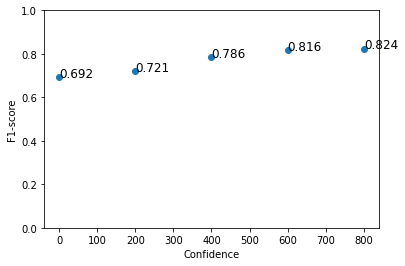

In [ ]:
f1_x = [0,200,400,600,800]
f1_y = [np.mean(f1_0),np.mean(f1_2),np.mean(f1_4),np.mean(f1_6),np.mean(f1_8)]

plt.scatter(f1_x,f1_y)
plt.xlabel('Confidence')
plt.ylabel('F1-score')
plt.ylim(0,1)

#use for loop to add annotations to each point in plot 
for i, txt in enumerate(f1_y):
    plt.annotate(round(txt,3), (f1_x[i]+.25, f1_y[i]), fontsize=12)

plt.show()